# Import libraries

In [93]:
import keras
import pandas as pd
import numpy as np
from tqdm import tqdm

import re, string, unicodedata
from string import punctuation
import inflect
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import SnowballStemmer

import seaborn as sns; sns.set()
import h5py

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten, Dropout, Add, Subtract, Multiply, Concatenate, Dot, Maximum
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM, Bidirectional
from keras.models import Model, Sequential

from sklearn.preprocessing import LabelBinarizer

import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
keras.__version__

'2.2.4'

### Import drugname_stopwords

In [3]:
drug_stopwords = pd.read_csv('drugname_stopwords.csv')
drug_stopwords = list(drug_stopwords.drugs_stopwords)

MAX_SEQUENCE_LENGTH = 100
MAX_NB_WORDS = 3000
EMBEDDING_DIM = 160

# Read dataset and change columns name

In [4]:
# Read dataset
df_train = pd.read_table('training_data.tsv')
df_test = pd.read_table('test_data.tsv')

# Change the name of columns
df_train.columns = ['Id','drugName','rating','effectiveness','sideEffects','condition','benefitsReview','sideEffectsReview','commentsReview']
df_test.columns = ['Id','drugName','rating','effectiveness','sideEffects','condition','benefitsReview','sideEffectsReview','commentsReview']

# Fill the NaN value comment into 'None'
df_train['commentsReview'] = df_train['commentsReview'].fillna("None")

# Split overall rating into 3 categories - Positive/Neutral/Negative

In [5]:
def rating_bin(array):
    y_rank =[]
    for i in array:
        if i <= 4:  # Negative
            y_rank.append('Negative')
        elif i >=7: #Positive
            y_rank.append('Positive')
        else:       #Neutral
            y_rank.append('Neutral')
    return y_rank

# Split overall rating of train and test set into 3 categories
df_train['class_label'] = rating_bin(df_train['rating'])
df_test['class_label'] = rating_bin(df_test['rating'])

# Make a variable to contain the class labels.
classes_to_predict = ['Positive','Neutral','Negative']
print(df_train['class_label'].value_counts())
print(df_test['class_label'].value_counts())

Positive    2130
Negative     661
Neutral      316
Name: class_label, dtype: int64
Positive    670
Negative    241
Neutral     125
Name: class_label, dtype: int64


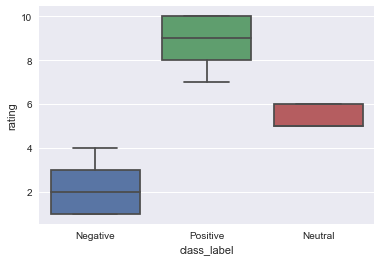

In [6]:
# Show the coverage for each group by its rating.
sns.boxplot(x='class_label', y="rating", data=df_train)
plt.show()

In [7]:
df_train.head()

,Id,drugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview,class_label
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ...",Negative
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest...",Negative
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...,Positive
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...,Negative
4,1951,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above,Negative


# Preprocessing commentsReview

In [8]:
# Concat benefitsReview & sideEffectsReview to commentsReview
# This may help overall commentsReview has more vocabulary of benefits words or sideeffects words
df_train['commentsReview'] = df_train['commentsReview'] + ' ' + df_train['benefitsReview'] + ' ' + df_train['sideEffectsReview']
df_test['commentsReview'] = df_test['commentsReview'] + ' ' + df_test['benefitsReview'] + ' ' + df_test['sideEffectsReview']

In [9]:
df_train.commentsReview[0]

'monitor blood pressure , weight and asses for resolution of fluid slowed the progression of left ventricular dysfunction into overt heart failure \r\r\nalone or with other agents in the managment of hypertension \r\r\nmangagement of congestive heart failur cough, hypotension , proteinuria, impotence , renal failure , angina pectoris , tachycardia , eosinophilic pneumonitis, tastes disturbances , anusease anorecia , weakness fatigue insominca weakness'

In [10]:
df_train.commentsReview[1]

"I Hate This Birth Control, I Would Not Suggest This To Anyone. Although this type of birth control has more cons than pros, it did help with my cramps. It's also effective with the prevention of pregnancy. (Along with use of condoms as well) Heavy Cycle, Cramps, Hot Flashes, Fatigue, Long Lasting Cycles. It's only been 5 1/2 months, but i'm concidering changing to a different bc. This is my first time using any kind of bc, unfortunately due to the constant hassel, i'm not happy with the results."

## Preprocessing steps
    * Lower case all the character to avoid the different between uppercase and lowercase
    * Remove all punctuations & special character & numbers
    * Remove all stopwords (common english stopwords + drugname stopwords)
    * Remove some top frequent words

In [11]:
# freq_words = pd.Series(' '.join(df_train['commentsReview']).split()).value_counts()[:10]
# freq_words = list(freq_words.index)

In [12]:
def clean_up_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"(\d)", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.lower()
    return df

In [13]:
df_train_clean_commentsReview = clean_up_text(df_train, 'commentsReview')
df_test_clean_commentsReview = clean_up_text(df_test, 'commentsReview')
df_train_clean_commentsReview.head()

,Id,drugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview,class_label
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ...",Negative
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","i hate this birth control, i would not suggest...",Negative
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,i took pills at the onset of my menstrual cra...,Positive
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",i was given prilosec prescription at a dose of...,Negative
4,1951,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,see above i think that the lyrica was starting...,Negative


In [14]:
df_train.commentsReview[1]

"i hate this birth control, i would not suggest this to anyone  although this type of birth control has more cons than pros, it did help with my cramps  it's also effective with the prevention of pregnancy  (along with use of condoms as well) heavy cycle, cramps, hot flashes, fatigue, long lasting cycles  it's only been    months, but i'm concidering changing to a different bc  this is my first time using any kind of bc, unfortunately due to the constant hassel, i'm not happy with the results "

    * Create a token column contain the list tokens of words

In [15]:
tokenize = RegexpTokenizer(r'\w+')
df_train['token'] = df_train['commentsReview'].apply(tokenize.tokenize)
df_train.head()

,Id,drugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview,class_label,token
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ...",Negative,"[monitor, blood, pressure, weight, and, asses,..."
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","i hate this birth control, i would not suggest...",Negative,"[i, hate, this, birth, control, i, would, not,..."
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,i took pills at the onset of my menstrual cra...,Positive,"[i, took, pills, at, the, onset, of, my, menst..."
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",i was given prilosec prescription at a dose of...,Negative,"[i, was, given, prilosec, prescription, at, a,..."
4,1951,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,see above i think that the lyrica was starting...,Negative,"[see, above, i, think, that, the, lyrica, was,..."


In [16]:
# from textblob import TextBlob

In [17]:
# Regex for removing non-alphanumeric characters and spaces
remove_special_char = re.compile('r[^a-z\d]',re.IGNORECASE)

# Regex to replace all numerics
replace_numerics = re.compile(r'\d+',re.IGNORECASE)

# F&#K Unicode Emojis
emoji_pattern = re.compile("["
                       u"\U0001F600-\U0001F64F"  # emoticons
                       u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                       u"\U0001F680-\U0001F6FF"  # transport & map symbols
                       u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                       u"\U00002702-\U000027B0"
                       u"\U000024C2-\U0001F251"
                       u"\U0001f926-\U0001f937"
                       u"\u200d"
                       u"\u2640-\u2642" 
                       "]+", flags=re.UNICODE)

# Load NLTK stop words
stop_words = nltk.corpus.stopwords.words('english')
print ("NLTK stopword list length: ",len(stop_words),'words')

# Add custom drug stopwords
# I have already saved it to drug_stopwords.csv in exploration dataset.ipynb
# stop_words.extend(drug_stopwords)
stop_words = drug_stopwords
print ("Added custom stopwords")
print ("New stopword list length: ",len(stop_words),'words')


def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stop_words:
            new_words.append(word)
    return new_words

# def correct_spelling(words):
#     """Correct spelling - This will take a lot of time"""
#     new_words = []
#     for word in words:
#         TextBlob(word).correct()
#         new_words.append(word)
#     return new_words

def normalize(words):
    words = remove_non_ascii(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = remove_stopwords(words)
#     words = correct_spelling(words)
    return words


def preprocess_text(text, remove_stopwords = True, perform_stemming = True):
    #first clean text then go to lowercase and split.
    text = text.replace(r"http\S+", "")
    text = text.replace(r"http", "")
    text = text.replace(r"(\d)", "")
    text = text.replace(r"@\S+", "")
    text = text.replace(r"@", "at")
    text = remove_special_char.sub('', text)
    text = replace_numerics.sub('n', text)
    text = emoji_pattern.sub('', text)
    text = text.replace( r"(\\r)|(\\n)|(\\t)|(\\f)|(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])|(&#039;)|(\d\s)|(\d)|(\/)","")
    text = text.replace( r"(\-)|(\\)|(\s{2,})"," ")
    text = text.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    text = text.replace(r"(&#n;)", "")
    
    # per/wordprocessing
    textlist = text.lower().split()
    textlist = normalize(textlist)
    text = ' '.join(textlist) 
  
    # stemming  
    if(perform_stemming):
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = ' '.join(stemmed_words)
        
    return text

NLTK stopword list length:  179 words
Added custom stopwords
New stopword list length:  663 words


In [18]:
all_words = [word for token in df_train["token"] for word in token]
df_train["token_len"] = [len(token) for token in df_train["token"]]
VOCAB = sorted(list(set(all_words)))

print("There are %s tokens in total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))

There are 365096 tokens in total, with a vocabulary size of 13215


    * Normalize all the tokens and create an "old_tokens" columns to compare

In [19]:
df_train['old_token'] = df_train["token"]
df_train['token'] = [normalize(token) for token in tqdm(df_train["token"])]

100%|██████████| 3107/3107 [00:02<00:00, 1243.29it/s]


In [20]:
df_train.head()

,Id,drugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview,class_label,token,token_len,old_token
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ...",Negative,"[monitor, blood, pressure, weight, asses, reso...",55,"[monitor, blood, pressure, weight, and, asses,..."
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","i hate this birth control, i would not suggest...",Negative,"[hate, birth, control, would, suggest, anyone,...",91,"[i, hate, this, birth, control, i, would, not,..."
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,i took pills at the onset of my menstrual cra...,Positive,"[took, pills, onset, menstrual, cramps, every,...",122,"[i, took, pills, at, the, onset, of, my, menst..."
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",i was given prilosec prescription at a dose of...,Negative,"[given, prescription, dose, mg, per, day, medi...",162,"[i, was, given, prilosec, prescription, at, a,..."
4,1951,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,see above i think that the lyrica was starting...,Negative,"[see, think, starting, help, pain, side, effec...",52,"[see, above, i, think, that, the, lyrica, was,..."


In [21]:
df_train.commentsReview.isnull().any().any()

False

In [22]:
df_train.old_token[1]

['i',
 'hate',
 'this',
 'birth',
 'control',
 'i',
 'would',
 'not',
 'suggest',
 'this',
 'to',
 'anyone',
 'although',
 'this',
 'type',
 'of',
 'birth',
 'control',
 'has',
 'more',
 'cons',
 'than',
 'pros',
 'it',
 'did',
 'help',
 'with',
 'my',
 'cramps',
 'it',
 's',
 'also',
 'effective',
 'with',
 'the',
 'prevention',
 'of',
 'pregnancy',
 'along',
 'with',
 'use',
 'of',
 'condoms',
 'as',
 'well',
 'heavy',
 'cycle',
 'cramps',
 'hot',
 'flashes',
 'fatigue',
 'long',
 'lasting',
 'cycles',
 'it',
 's',
 'only',
 'been',
 'months',
 'but',
 'i',
 'm',
 'concidering',
 'changing',
 'to',
 'a',
 'different',
 'bc',
 'this',
 'is',
 'my',
 'first',
 'time',
 'using',
 'any',
 'kind',
 'of',
 'bc',
 'unfortunately',
 'due',
 'to',
 'the',
 'constant',
 'hassel',
 'i',
 'm',
 'not',
 'happy',
 'with',
 'the',
 'results']

In [23]:
df_train.token[1]

['hate',
 'birth',
 'control',
 'would',
 'suggest',
 'anyone',
 'although',
 'type',
 'birth',
 'control',
 'cons',
 'pros',
 'help',
 'cramps',
 'also',
 'effective',
 'prevention',
 'pregnancy',
 'along',
 'use',
 'condoms',
 'well',
 'heavy',
 'cycle',
 'cramps',
 'hot',
 'flashes',
 'fatigue',
 'long',
 'lasting',
 'cycles',
 'months',
 'concidering',
 'changing',
 'different',
 'bc',
 'first',
 'time',
 'using',
 'kind',
 'bc',
 'unfortunately',
 'due',
 'constant',
 'hassel',
 'happy',
 'results']

### Export cleaned_normalized data for later use

In [24]:
df_train.to_csv("cleaned_normalized_data.csv")

In [25]:
# Features AFTER normalizing & removing stopwords

cleaned_words = [word for token in df_train["token"] for word in token]
df_train["token_len"] = [len(token) for token in df_train["token"]]
cleanedVOCAB = sorted(list(set(all_words)))

print("There are %s words total, with a vocabulary size of %s" % (len(all_words), len(cleanedVOCAB)))
print("We got rid of {} words, or {:2.3f}% of the total token count".format((len(all_words)-len(cleaned_words)),(len(cleaned_words) / len(all_words)*100)))

There are 365096 words total, with a vocabulary size of 13215
We got rid of 178681 words, or 51.059% of the total token count


In [26]:
len(cleaned_words)

186415

In [27]:
len(all_words)

365096

In [28]:
print ("Before cleaning")
# See some of the words left in our vocab. 
df_words = []
df_words = pd.DataFrame(all_words)
words = df_words[0].value_counts()
print(words.head(5), words.tail(5))

# See some of the words left in our vocab. 

print ("\nAfter cleaning")
df_words = []
df_words = pd.DataFrame(cleaned_words)
words = df_words[0].value_counts()
print(words.head(5), words.tail(5))

Before cleaning
i      16486
the    15047
to     10624
and    10511
a       7642
Name: 0, dtype: int64 nuclear        1
preparation    1
hearted        1
relearn        1
dap            1
Name: 0, dtype: int64

After cleaning
day        2017
side       1985
effects    1816
take       1737
taking     1703
Name: 0, dtype: int64 alo         1
interfer    1
gon         1
floaty      1
shuffle     1
Name: 0, dtype: int64


# Bag of Words Counts

In [29]:
df_clean_text = pd.read_csv("cleaned_normalized_data-spelling correct.csv")
df_train_to_list = pd.DataFrame(df_clean_text["token"])
df_train_to_list = df_clean_text.token.tolist()
print(df_clean_text["class_label"].values)

['Negative' 'Negative' 'Positive' ... 'Negative' 'Positive' 'Negative']


In [30]:
len(df_train_to_list)

3107

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#Defining vectorizer function
def cv(data):
    count_vectorizer = CountVectorizer()
    
    a = count_vectorizer.fit_transform(data)
    
    return a, count_vectorizer

In [32]:
#
list_tokens = df_train_to_list
list_labels = []
for x in df_train['class_label']:
    if x == 'Negative':
        list_labels.append(0)
    elif x == 'Positive':
        list_labels.append(1)
    else:
        list_labels.append(2)

In [33]:
len(list_labels)

3107

In [34]:
#Split dataset
X_train, X_test, y_train, y_test = train_test_split(list_tokens, list_labels, test_size=0.2, random_state=2019)

In [35]:
X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

In [36]:
X_train_counts

<2485x11412 sparse matrix of type '<class 'numpy.int64'>'
	with 120744 stored elements in Compressed Sparse Row format>

In [37]:
X_test_counts

<622x11412 sparse matrix of type '<class 'numpy.int64'>'
	with 29916 stored elements in Compressed Sparse Row format>

In [38]:
count_vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [39]:
len(y_test)

622

In [40]:
len(y_train)

2485

# BOW embedding visualization

colormapper= {0: 0, 1: 1, 2: 2}


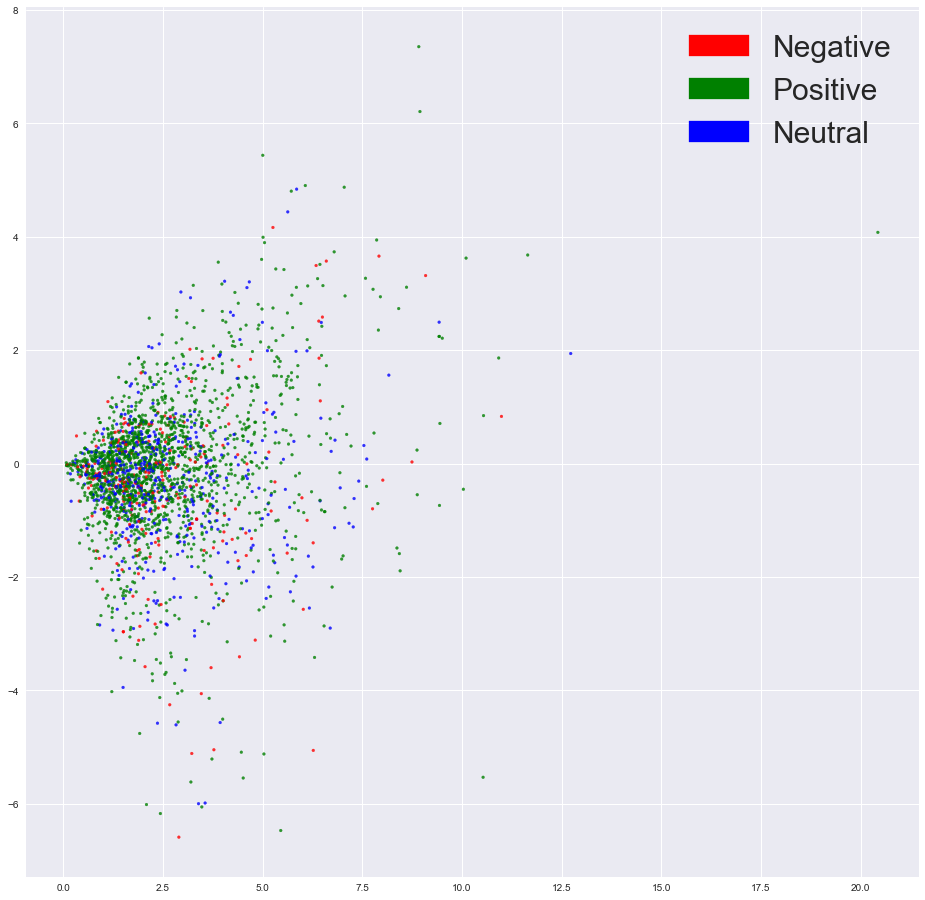

In [41]:
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        print ('colormapper=',color_mapper)
        #print ('colorColumn=',color_column)
        colors = ['blue','green','red']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='red', label='Negative')
            blue_patch = mpatches.Patch(color='blue', label='Neutral')
            green_patch = mpatches.Patch(color='green', label='Positive')
            plt.legend(handles=[red_patch, green_patch, blue_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_counts, y_train)
plt.show()

The embedding dont look too seperated. Try to fit a model on them

In [42]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30, class_weight='balanced', solver='sag', 
                         multi_class='multinomial', n_jobs=-1, random_state=40, 
                         verbose=1, max_iter = 2000)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

convergence after 1563 epochs took 6 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.1s finished


In [43]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.701, precision = 0.688, recall = 0.701, f1 = 0.694


In [44]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

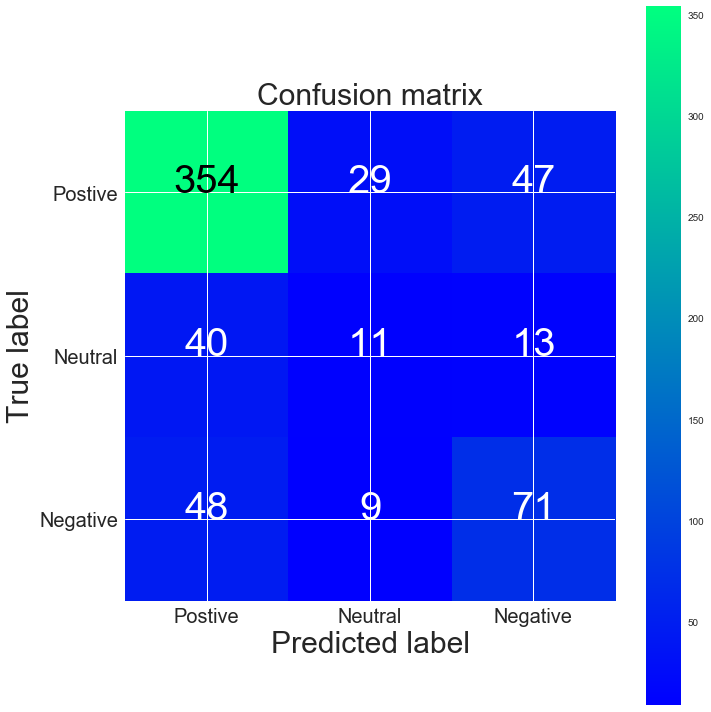

Test Data Value Counts:
 1    430
0    128
2     64
Name: 0, dtype: int64


In [45]:
cm = confusion_matrix(y_test, y_predicted_counts, labels=[1,2,0])
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Postive','Neutral','Negative'], normalize=False, title='Confusion matrix')
plt.show()

pd_y_test = pd.DataFrame(y_test)
print("Test Data Value Counts:\n", pd_y_test[0].value_counts())

The classifier predicted class 3 - Neutral is not so good but other 2 are ok ... 

## Get most important words

In [46]:
# Gets a list of the most important and least important word vectors

def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)

In [47]:
importance

{0: {'bottom': [(-0.9965945412005953, 'looked'),
   (-1.0124287427116119, 'loose'),
   (-1.0346760888177855, 'quite'),
   (-1.0381509048533635, 'dryness'),
   (-1.0447697557127018, 'miracle'),
   (-1.1290067297089104, 'drowsiness'),
   (-1.1415687030234278, 'allowed'),
   (-1.333824401712112, 'needed'),
   (-1.3536764602047, 'occasional'),
   (-1.369797211294802, 'significantly')],
  'tops': [(1.2051002072578516, 'coughing'),
   (1.2267918601014678, 'improvement'),
   (1.2365172819891925, 'ache'),
   (1.2702710370026453, 'extreme'),
   (1.3602341396933992, 'tabs'),
   (1.3812305915780776, 'told'),
   (1.410871591590934, 'new'),
   (1.5084188828352454, 'intolerable'),
   (1.6819747970284025, 'discontinued'),
   (1.8545841787667954, 'horrible')]},
 1: {'bottom': [(-1.1858858069321638, 'withdrawal'),
   (-1.1961201734805673, 'qd'),
   (-1.2258221257309898, 'doubled'),
   (-1.264008547847284, 'proactiv'),
   (-1.287084908896703, 'discontinued'),
   (-1.3221889183312077, 'vomiting'),
   (-1

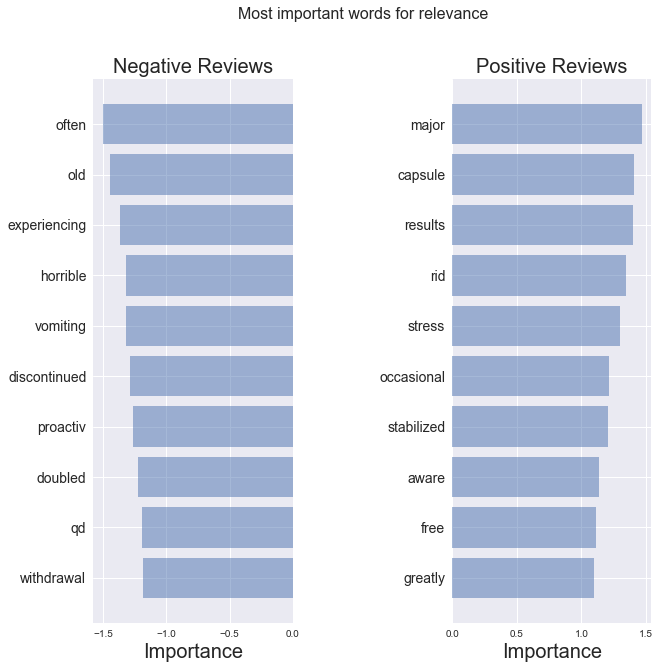

In [48]:
# Define important words plot function and plot Bag-of-Words' important words

def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Negative Reviews', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Positive Reviews', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[1]['tops']]
top_words = [a[1] for a in importance[1]['tops']]
bottom_scores = [a[0] for a in importance[1]['bottom']]
bottom_words = [a[1] for a in importance[1]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

Classifier picked up some bad words in negative review (horrible, vomiting). And also picked some good words in possitive review (free, greatly, stabilized)

# Try TFIDF (Term Frequency, Inverse Document Frequency)

In [49]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

colormapper= {0: 0, 1: 1, 2: 2}


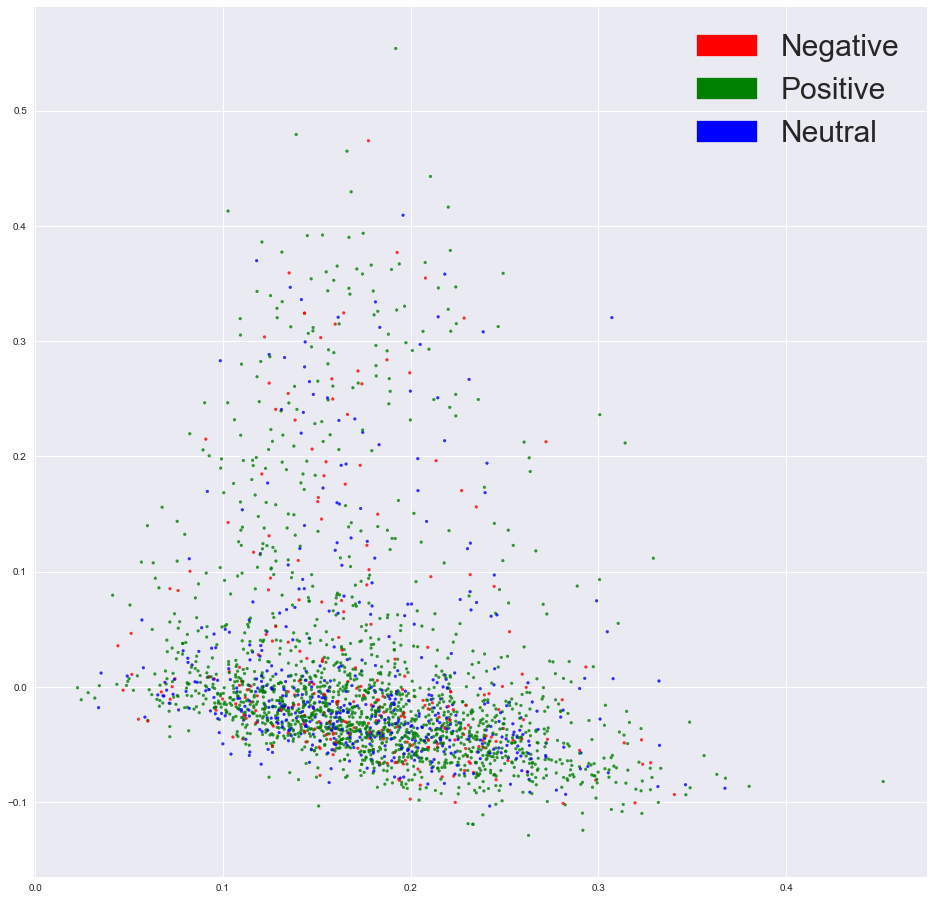

In [50]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

This embeddings look much more seperated than BOW ...

In [51]:
clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='sag', 
                         multi_class='multinomial', n_jobs=-1, random_state=40, verbose=1, max_iter = 2000)
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

convergence after 90 epochs took 0 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


In [52]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf))

accuracy = 0.704, precision = 0.679, recall = 0.704, f1 = 0.690


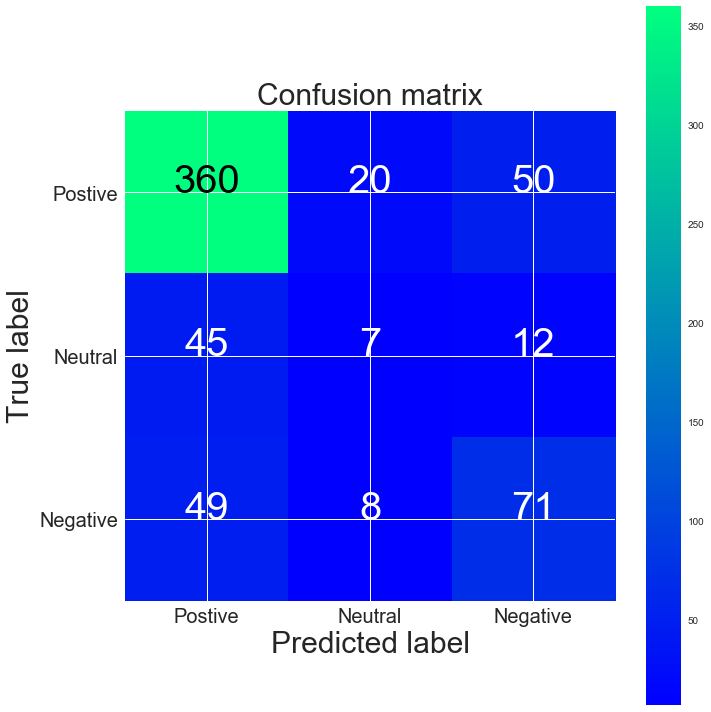

Test Data Value Counts:
 1    430
0    128
2     64
Name: 0, dtype: int64
TFIDF confusion matrix
[[360  20  50]
 [ 45   7  12]
 [ 49   8  71]]
BoW confusion matrix
[[354  29  47]
 [ 40  11  13]
 [ 48   9  71]]


In [53]:
cm2 = confusion_matrix(y_test, y_predicted_tfidf, labels=[1,2,0])
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=['Postive','Neutral','Negative'], normalize=False, title='Confusion matrix')
plt.show()

pd_y_test = pd.DataFrame(y_test)
print("Test Data Value Counts:\n", pd_y_test[0].value_counts())

print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

This model performed not as good as BOW model for me.

In [54]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 10)

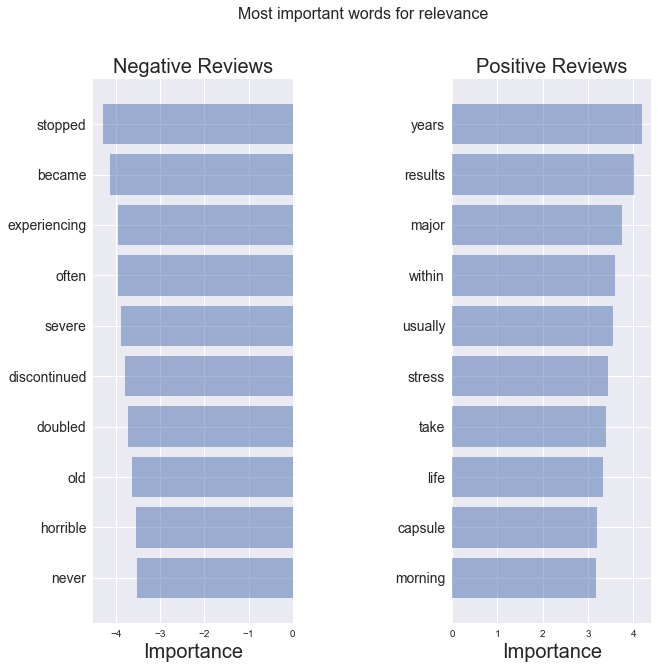

In [55]:
top_scores = [a[0] for a in importance_tfidf[1]['tops']]
top_words = [a[1] for a in importance_tfidf[1]['tops']]
bottom_scores = [a[0] for a in importance_tfidf[1]['bottom']]
bottom_words = [a[1] for a in importance_tfidf[1]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

# Apply LSTM model to our data processed text

# Clean up the text

In [56]:
# Define y for Training/Validation 
y = pd.get_dummies(df_train['class_label']).values

# Define y for Tests
y_test_predicted = pd.get_dummies(df_test['class_label']).values

print ('Raw comments: \n', df_train.commentsReview[1:10])

Raw comments: 
 1    i hate this birth control, i would not suggest...
2    i took  pills at the onset of my menstrual cra...
3    i was given prilosec prescription at a dose of...
4    see above i think that the lyrica was starting...
5    one pill once daily after taking propecia for ...
6    i had began taking mg of vyvanse for three mon...
7    one a day, taken about an hour before bedtime ...
8    i first started taking this at  times per day ...
9    took one  mg pill nightly  none   did nothing ...
Name: commentsReview, dtype: object


In [57]:
# Process commentsReview for Training(X)
processed_train_comments = []
for comment in tqdm(df_train.commentsReview):
    processed_train_comments.append(preprocess_text(comment))

# Process commentsReview for Testing(X)
processed_test_comments = []    
for comment in tqdm(df_test.commentsReview):
    processed_test_comments.append(preprocess_text(comment))

print ('Processed comments: \n',processed_train_comments[1:10])

100%|██████████| 1036/1036 [00:01<00:00, 558.37it/s]


Processed comments: 
 ['hate birth control would suggest anyon although type birth control con pros help cramp also effect prevent pregnanc along use condom well heavi cycl cramp hot flash fatigu long last cycl month im concid chang differ bc first time use kind bc unfortun due constant hassel im happi result', 'took pill onset menstrual cramp everi hour took pill need foabout day cramp ove cramp bad make sure take everi hour dot medic stop work sudden unfortun take houto houand half kick back cramp moder take everi hour okay use cramp bad would leav ball bed foat least day doesnt take pain away complet take edg much normal activ possibl definit miracl medic heaviebleed clot normal', 'given prescript dose mg peday medic taken everi morn eat treatment durat fo month acid reflux went away foa month aftejust day drug heartburn start soon stop take began treatment month pass stop take heartburn came back seem wors even doctosaid tri anoth month treatment exact thing happen went foabout thr

### Save train/test processed text data and labels to csv file for later use

In [58]:
np.savetxt("y_train.csv", y, delimiter=",", fmt='%s')
np.savetxt("y_test.csv", y_test_predicted, delimiter=",", fmt='%s')
np.savetxt("processed_train_comments.csv", processed_train_comments, delimiter=",", fmt='%s')
np.savetxt("processed_test_comments.csv", processed_test_comments, delimiter=",", fmt='%s')

In [59]:
processed_train_comments = [line.strip() for line in open("processed_train_comments.csv", 'r')]
processed_test_comments = [line.strip() for line in open("processed_test_comments.csv", 'r')]
y = np.loadtxt(open("y_train.csv", "r"), delimiter=",").astype("int")
y_test_predicted = np.loadtxt(open("y_test.csv", "rb"), delimiter=",").astype("int")

print(len(processed_train_comments))
print(len(y))
print(len(processed_test_comments))
print(len(y_test_predicted))

3107
3107
1036
1036


In [60]:
#Merge into an train processed dataset
train_df_processed = pd.DataFrame(y)
train_df_processed[3] = processed_train_comments
len(train_df_processed)

3107

In [61]:
train_df_processed.head(10)

,0,1,2,3
0,1,0,0,monitoblood pressur weight ass foresolut fluid...
1,1,0,0,hate birth control would suggest anyon althoug...
2,0,0,1,took pill onset menstrual cramp everi hour too...
3,1,0,0,given prescript dose mg peday medic taken ever...
4,1,0,0,see think start help pain side effect sever co...
5,1,0,0,one pill daili aftetak propecia foovea yea sta...
6,0,0,1,began take mg fothre month surpris find small ...
7,0,0,1,one day taken houbefor bedtim although drug or...
8,0,0,1,first start take time peday mg pill advis take...
9,1,0,0,took one mg pill night none noth help allergi ...


In [62]:
print(train_df_processed[3].str.split().str.len().mean())
print(train_df_processed[3].str.split().str.len().max())
train_df_processed["strlen"] = train_df_processed[3].str.split().str.len()

60.77019633086579
415


In [63]:
train_df_processed.head(10)

,0,1,2,3,strlen
0,1,0,0,monitoblood pressur weight ass foresolut fluid...,40
1,1,0,0,hate birth control would suggest anyon althoug...,49
2,0,0,1,took pill onset menstrual cramp everi hour too...,66
3,1,0,0,given prescript dose mg peday medic taken ever...,82
4,1,0,0,see think start help pain side effect sever co...,24
5,1,0,0,one pill daili aftetak propecia foovea yea sta...,44
6,0,0,1,began take mg fothre month surpris find small ...,67
7,0,0,1,one day taken houbefor bedtim although drug or...,31
8,0,0,1,first start take time peday mg pill advis take...,194
9,1,0,0,took one mg pill night none noth help allergi ...,52


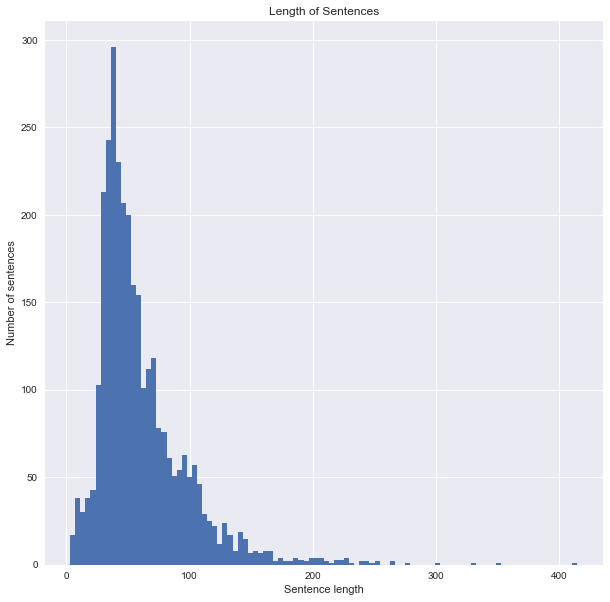

In [64]:
fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.title('Length of Sentences')
plt.hist(train_df_processed["strlen"], bins=MAX_SEQUENCE_LENGTH)
plt.show()

In [65]:
train_df_processed.describe()

,0,1,2,strlen
count,3107.000000,3107.000000,3107.000000,3107.000000
mean,0.212745,0.101706,0.685549,60.770196
std,0.409315,0.302310,0.464372,37.720530
min,0.000000,0.000000,0.000000,3.000000
25%,0.000000,0.000000,0.000000,36.000000
50%,0.000000,0.000000,1.000000,50.000000
75%,0.000000,0.000000,1.000000,75.000000
max,1.000000,1.000000,1.000000,415.000000


In [66]:
_a = train_df_processed.loc[train_df_processed["strlen"] >= 1000].strlen.count()
_b = train_df_processed.loc[train_df_processed["strlen"] >= 750].strlen.count()
_c = train_df_processed.loc[train_df_processed["strlen"] >= 250].strlen.count()
_d = train_df_processed.loc[train_df_processed["strlen"] >= 180].strlen.count()
_e = train_df_processed.loc[train_df_processed["strlen"] >= 100].strlen.count()
_f = train_df_processed.loc[train_df_processed["strlen"] < 100].strlen.count()
print (" # of Reviews by Length \n %s >1000 words \n %s >750 words \n %s >250 words \n %s >180 words \n %s >100 words \n %s <100 words\n" % (_a,_b,_c,_d,_e,_f))

 # of Reviews by Length 
 0 >1000 words 
 0 >750 words 
 9 >250 words 
 52 >180 words 
 393 >100 words 
 2714 <100 words



New word count mean: 50.0542920029347
New word count max: 100


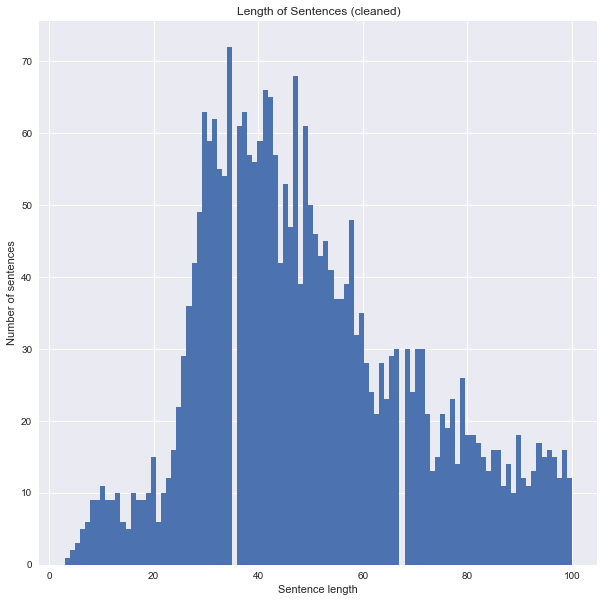

In [67]:
# Drop very long rows
train_df_processed = train_df_processed.loc[train_df_processed["strlen"] <= MAX_SEQUENCE_LENGTH]

print("New word count mean:", train_df_processed[3].str.split().str.len().mean())
print("New word count max:",train_df_processed[3].str.split().str.len().max())
train_df_processed.describe()

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.title('Length of Sentences (cleaned)')
plt.hist(train_df_processed["strlen"], bins=MAX_SEQUENCE_LENGTH)
plt.show()

# Post processing and drop y columns

In [68]:
post_processed_train_comments = train_df_processed[3].tolist()
post_processed_y = train_df_processed[[0, 1, 2]].values

print('y: \n',y[0:5])
print('post_y: \n',post_processed_y[0:5])

print('pre_train comments: \n',processed_train_comments[0:3])
print('post_train comments: \n',post_processed_train_comments[0:3])

print('y_test:\n',y_test_predicted[0:5])
print('x_test:\n',processed_test_comments[0:3])

y: 
 [[1 0 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [1 0 0]]
post_y: 
 [[1 0 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [1 0 0]]
pre_train comments: 
 ['monitoblood pressur weight ass foresolut fluid slow progress left ventriculadysfunct overt heart failur alon owith otheag manag hypertens mangag congest heart failucough hypotens proteinuria impot renal failur angina pectori tachycardia eosinophil pneumon tast disturb anuseas anorecia weak fatigu insominca weak', 'hate birth control would suggest anyon although type birth control con pros help cramp also effect prevent pregnanc along use condom well heavi cycl cramp hot flash fatigu long last cycl month im concid chang differ bc first time use kind bc unfortun due constant hassel im happi result', 'took pill onset menstrual cramp everi hour took pill need foabout day cramp ove cramp bad make sure take everi hour dot medic stop work sudden unfortun take houto houand half kick back cramp moder take everi hour okay use cramp bad would leav ball bed foat least 

# Create vector, tokenizer with encoded label

In [69]:
# Tokenize the data
tokenizer = Tokenizer(num_words = MAX_NB_WORDS, 
                      filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',
                      lower=True, split=' ', char_level=False, 
                      oov_token=None, document_count=0)

tokenizer.fit_on_texts(post_processed_train_comments + processed_test_comments)

In [70]:
# Convert to sequences
train_sequences = tokenizer.texts_to_sequences(post_processed_train_comments)
test_sequences = tokenizer.texts_to_sequences(processed_test_comments)
word_index = tokenizer.word_index
print('found %s tokens in text.' %(len(word_index)))

# Ensure all sequences have the same length. 
train_data = pad_sequences(train_sequences, maxlen = MAX_SEQUENCE_LENGTH)
final_test_data = pad_sequences(test_sequences, maxlen = MAX_SEQUENCE_LENGTH)

# Print shapes of data. 
print(train_data.shape, '<-- shape of train_data ready for val/train split.')
print(final_test_data.shape, '<-- shape of final_test_data ready for fedding to network.')
print(len(word_index), '<-- Length of Word Index')

found 15020 tokens in text.
(2726, 100) <-- shape of train_data ready for val/train split.
(1036, 100) <-- shape of final_test_data ready for fedding to network.
15020 <-- Length of Word Index


# Train/Validation split

In [71]:
X_train, X_val, Y_train, Y_val = train_test_split(train_data, post_processed_y,
                                                  test_size = 0.2,  stratify= post_processed_y, 
                                                  random_state = 2019)
X_test = final_test_data
Y_test = y_test_predicted

print('train data shape:', X_train.shape)
print('validation data shape:', X_val.shape)

train data shape: (2180, 100)
validation data shape: (546, 100)


# Setup the LSTM model

In [72]:
nb_words  = min(MAX_NB_WORDS, len(word_index))
lstm_out = MAX_SEQUENCE_LENGTH

model = Sequential()
model.add(Embedding(nb_words, EMBEDDING_DIM, input_length=lstm_out))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(3, activation = 'softmax'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [73]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 160)          480000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 160)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               104400    
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 584,703
Trainable params: 584,703
Non-trainable params: 0
_________________________________________________________________


# Fit on dataset

In [74]:
name = "Drug_"
variant = "LSTM_"
title = name + variant

training_cycle = 5
batch = 32
stamp = '{}training_cycle{}_batchsize_{}'.format(title, training_cycle, batch)
print(stamp)

Drug_LSTM_training_cycle5_batchsize_32


In [75]:
best_model_path = title + stamp + '_best.h5'

early_stopping = EarlyStopping(patience = 4)
model_checkpoint = ModelCheckpoint(best_model_path, save_best_only = True)


# Run LSTM Model
epoch = 100
LSTM_model = model.fit(X_train, Y_train, batch_size=batch, epochs=epoch,
                       validation_data=(X_val, Y_val), shuffle = True, 
                       callbacks = [early_stopping, model_checkpoint], verbose = 0)
best_score = min(LSTM_model.history['val_loss'])


# Save Training History
df_fit = pd.DataFrame(columns=['loss','acc','val_loss','val_acc'])
df_fit['loss'] = LSTM_model.history['loss']
df_fit['val_loss'] = LSTM_model.history['val_loss']
df_fit['acc'] = LSTM_model.history['acc']
df_fit['val_acc'] = LSTM_model.history['val_acc']

# Save Model & Run Data 
save_name = ('DrugDataLSTM_batch_{}_epoch_{}_cycle_{}'.format(batch,epoch,training_cycle))
# Save the end model with the best score. 
model.save('{}_end.h5'.format(save_name))
print('Uploaded file {}.h5'.format(save_name))
# Save df of run performance
df_fit.to_csv('{}.csv'.format(save_name))
print('Uploaded file {}.csv'.format(save_name))

Uploaded file DrugDataLSTM_batch_32_epoch_100_cycle_5.h5
Uploaded file DrugDataLSTM_batch_32_epoch_100_cycle_5.csv


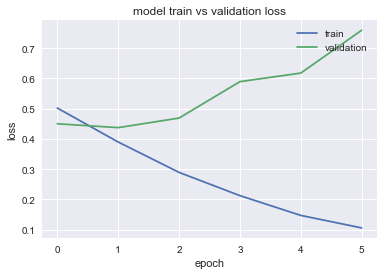

In [76]:
plt.plot(LSTM_model.history['loss'])
plt.plot(LSTM_model.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

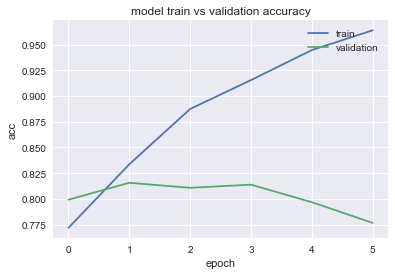

In [77]:
plt.plot(LSTM_model.history['acc'])
plt.plot(LSTM_model.history['val_acc'])
plt.title('model train vs validation accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [79]:
from keras.models import load_model
model2 = load_model('DrugDataLSTM_batch_32_epoch_100_cycle_5_end.h5')

In [80]:
accr = model2.evaluate(X_test, Y_test, batch_size = 256)

1036/1036 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 450us/step


In [81]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.775
  Accuracy: 0.783


In [82]:
prediction = model2.predict(X_test)

In [83]:
prediction

array([[0.8362305 , 0.08586796, 0.0779015 ],
       [0.56629866, 0.14507313, 0.28862825],
       [0.7643758 , 0.22328238, 0.01234187],
       ...,
       [0.94620275, 0.04312434, 0.01067285],
       [0.06469452, 0.02421844, 0.91108704],
       [0.0183414 , 0.0337883 , 0.9478704 ]], dtype=float32)

In [84]:
target_names = ['Positive','Neutral','Negative']
print(confusion_matrix(Y_test.argmax(axis=1), prediction.argmax(axis=1)))

[[128  12 101]
 [ 24  15  86]
 [ 84  44 542]]


In [85]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

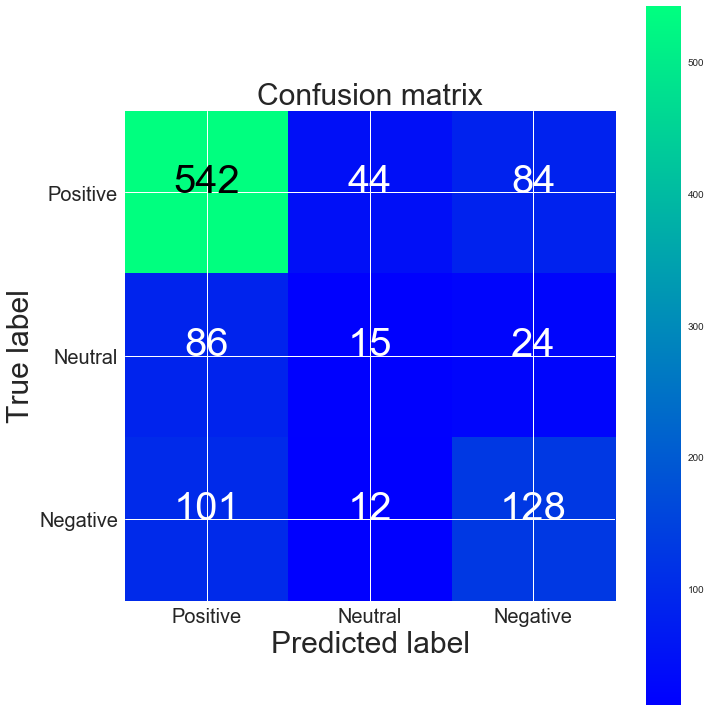

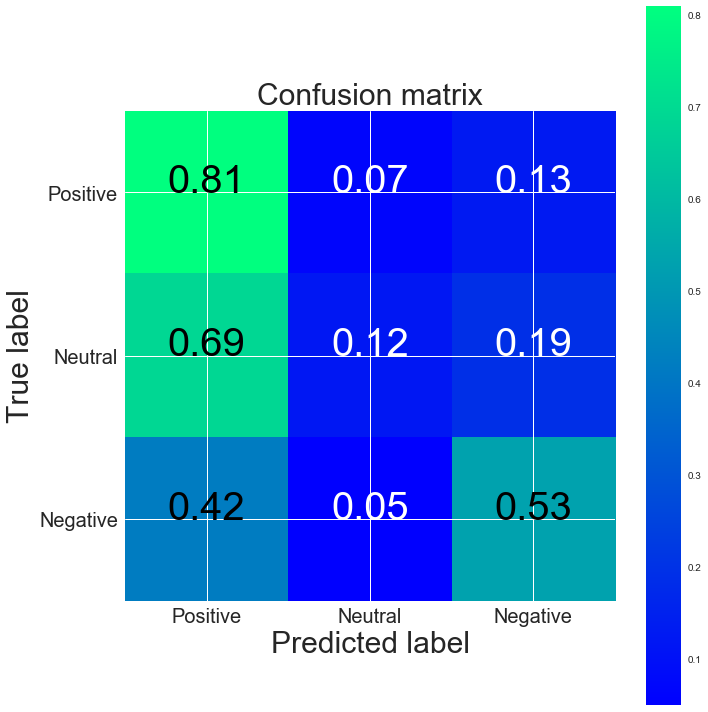

Incase we've forgotten
Test Data Value Counts:
 Positive    670
Negative    241
Neutral     125
Name: class_label, dtype: int64


In [86]:
cm = confusion_matrix(Y_test.argmax(axis=1), prediction.argmax(axis=1), labels = [2,1,0])
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Positive','Neutral','Negative'], normalize=False, title='Confusion matrix')
plt.show()

cm = confusion_matrix(Y_test.argmax(axis=1), prediction.argmax(axis=1), labels = [2,1,0])
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Positive','Neutral','Negative'], normalize=True, title='Confusion matrix')
plt.show()

print("Incase we've forgotten")
print("Test Data Value Counts:\n", df_test['class_label'].value_counts())

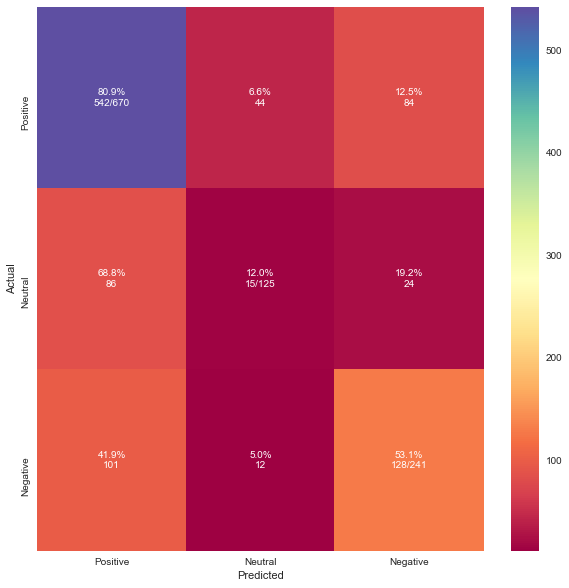

In [105]:
labels = ['Positive','Neutral','Negative']

def cm_analysis(y_true, y_pred, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)

    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, cmap="Spectral")
    plt.savefig('LSTM model accuracy')
    plt.show()

cm_analysis(Y_test.argmax(axis=1), prediction.argmax(axis=1), ymap={0:"Negative",1:"Neutral",2:"Positive"}, figsize=(10,10))

## The LSTM model did good with Positive labels, ok with Negative but it performed very bad with Neutral label. I'm still finding the solution to solve and wonder why it did very bad with Neutral label.